In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd 'drive/My Drive/bep/AES-master'

/content/drive/My Drive/bep/AES-master


In [0]:
ls

 300features_40minwords_10context
 Classification_Methods_Final.ipynb
'Copy of Data_Cleaning_and_Transformation_Word2Vec_final.ipynb'
 Data_Cleaning_and_Transformation_Word2Vec_final.ipynb
 Data_Exploration_Final.ipynb
 dataloading1.py
 dataloading1.pyc
 essay2vec.py
 essay2vec.pyc
 essay2vec.py.gdoc
 logs/
 Neural_Network_Write_Up_final.ipynb
 __pycache__/
 README.md
 requiredimports.py
 requiredimports.pyc
 savetest.txt
 training_set_rel3.xlsx
 wordembedding.png


In [0]:
pip install runipy

  Created wheel for runipy: filename=runipy-0.1.5-cp27-none-any.whl size=10139 sha256=079bd8a275de6ef55a300e19b59806326afa0ab1f0964cab3d7b97d078cb49e9
  Stored in directory: /root/.cache/pip/wheels/38/80/04/b2dbcd5df8afdb529918d2021094048a5917b6e76a6f7b452d
Successfully built runipy


In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
pip install gensim==0.13.4.1

     |████████████████████████████████| 7.5MB 2.7MB/s 
  Created wheel for gensim: filename=gensim-0.13.4.1-cp27-cp27mu-linux_x86_64.whl size=4815602 sha256=f8d3ed94cedd1c57e134d4d26d7978e27c273a2b3256f539717267bae4d68e29
  Stored in directory: /root/.cache/pip/wheels/cc/4a/36/34fbd4f1e3a18fe5a2bb3d4366a44711ad0c34adc8251829d9
Successfully built gensim
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [0]:
pip install scikit-learn==0.18

In [0]:
!python requiredimports.py

In [0]:
pip install paramiko

     |████████████████████████████████| 215kB 2.8MB/s 
     |████████████████████████████████| 768kB 8.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 2.7MB 8.5MB/s 


In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import spearmanr
import nltk.data
import re
from nltk.corpus import stopwords
import tensorflow as tf
import logging
from gensim.models import word2vec
from sklearn.metrics import cohen_kappa_score
import timeit
from sklearn.model_selection import train_test_split
#from pandas import Series
from numpy.random import randn

xl_workbook = pd.ExcelFile('training_set_rel3.xlsx')
df_all = xl_workbook.parse("training_set")
df_all = df_all[df_all['domain1_score']<61]
df_all = df_all.dropna(axis = 1)
df_all = df_all.drop('rater1_domain1', 1)
df_all = df_all.drop('rater2_domain1', 1)
df_all = df_all.drop('essay_id', 1)

X_train, X_test, y_train, y_test = train_test_split(df_all['essay'], df_all['domain1_score'], test_size=0.10)
print(y_train)
print(len(y_train))
y_train = y_train.values.reshape((len(y_train),1))
print(y_train)
y_test = y_test.values.reshape((len(y_test), 1))
print(y_test)

def essay_to_wordlist(essay_v, remove_stopwords):
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def essay_to_sentences(essay_v, remove_stopwords):
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

sentences = []

for essay_v in X_train:    
    sentences += essay_to_sentences(essay_v, remove_stopwords = True)

for essay_v in X_test:
    sentences += essay_to_sentences(essay_v, remove_stopwords = True)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

model.init_sims(replace=True)

model_name = "300features_40minwords_10context"
model.save(model_name)

def makeFeatureVec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

print ("Creating average feature vecs for Training Essays")
clean_train_essays = []
for essay_v in X_train:
    clean_train_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
trainDataVecs = getAvgFeatureVecs( clean_train_essays, model, num_features )


clean_test_essays = []
for essay_v in X_test:
    clean_test_essays.append( essay_to_wordlist( essay_v, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
  

9984      3.0
5794      0.0
10064     3.0
1687      9.0
1474      7.0
3036      2.0
2070      4.0
12677    30.0
11252    20.0
7697      1.0
12356    40.0
9222      3.0
5672      2.0
11595    17.0
7660      3.0
1006      8.0
9120      4.0
1703      7.0
4342      1.0
1362      6.0
6324      1.0
10639     4.0
2741      3.0
8572      2.0
8657      3.0
8222      4.0
3559      5.0
4373      2.0
9869      3.0
6436      1.0
         ... 
7370      3.0
5934      0.0
8968      3.0
10150     2.0
11505     6.0
6382      2.0
2258      4.0
907       8.0
7945      1.0
7144      2.0
8887      3.0
11895    21.0
687       9.0
1619      8.0
3315      4.0
4598      2.0
7214      3.0
8919      2.0
8218      3.0
120       8.0
8402      2.0
629      10.0
5764      3.0
12723    32.0
9613      4.0
12544    40.0
3120      3.0
2853      3.0
11176    11.0
1791      4.0
Name: domain1_score, Length: 11679, dtype: float64
11679
[[ 3.]
 [ 0.]
 [ 3.]
 ...
 [ 3.]
 [11.]
 [ 4.]]
[[ 1.]
 [ 2.]
 [ 4.]
 ...
 [ 1.]
 [15.]
 

/usr/local/lib/python2.7/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Creating average feature vecs for Training Essays


In [0]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn import grid_search
from sklearn.svm import SVC
from time import time
import warnings
warnings.filterwarnings("ignore")

In [0]:
#initialize arrays to store results
times = []
scores = []
labels = []

In [0]:
#parameter combinations that will be tested
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader

parameters = {'class_weight': ['balanced', None], 'penalty': ['l1','l2']}
logreg = LogisticRegression()
log_grid = grid_search.GridSearchCV(logreg, parameters)
print (trainDataVecs)
log_grid.fit(trainDataVecs, y_train[:,0])
print (log_grid.best_params_)

[[ 0.0460921   0.02894035 -0.02239872 ...  0.00047606  0.01869415
   0.00498749]
 [ 0.02495375 -0.0126499  -0.00534976 ... -0.05037187  0.00939768
   0.01937776]
 [ 0.0235579   0.03032295 -0.02603593 ... -0.00293597  0.01692811
  -0.00283313]
 ...
 [-0.00261315 -0.02697613  0.00291556 ... -0.01252981  0.00496205
   0.02446349]
 [-0.01008684 -0.03900116  0.0087231  ... -0.03596007  0.04156557
   0.02154632]
 [ 0.00133886 -0.04026736  0.00392179 ... -0.02114516 -0.00584895
   0.02505936]]
{'penalty': 'l1', 'class_weight': None}


In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
start_lr = time()
logreg = LogisticRegression(penalty = 'l1', class_weight = None)
logreg.fit(trainDataVecs, y_train[:,0])
preds_lr  = logreg.predict(testDataVecs)
tot_lr = time() - start_lr

scores.append(spearmanr(y_test, preds_lr)[0])
times.append(tot_lr)
labels.append('Log Reg')

In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
#K Nearest Neighbors
start_knn = time()
knn = KNN(n_neighbors = 16)
knn.fit(trainDataVecs, y_train[:,0])
predsknn = knn.predict(testDataVecs)
tot_knn = time() - start_knn

scores.append(spearmanr(y_test, predsknn)[0])
times.append(tot_knn)
labels.append('KNN')

In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
#Support Vector Machine
start = time()
svm = SVC(C = 50, gamma = 0.9)
svm.fit(trainDataVecs, y_train[:,0])
predictions = svm.predict(testDataVecs)
total = time() - start

scores.append(spearmanr(y_test, predictions)[0])
times.append(total)
labels.append('SVM')

In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
#Random Forest
start_rf = time()
rf = RandomForest(n_estimators = 51, max_depth = 14)
rf.fit(trainDataVecs, y_train[:])
preds_rf = rf.predict(testDataVecs)
tot_rf = time() - start_rf 

scores.append(spearmanr(y_test, preds_rf)[0])
times.append(tot_rf)
labels.append('Random Forest')

Algorithm Time Score
Log Reg 17.0286509991 0.7827268366160818
KNN 4.16545701027 0.920571666918489
SVM 50.0607409477 0.9349743916634462
Random Forest 18.4566810131 0.9144732585850536


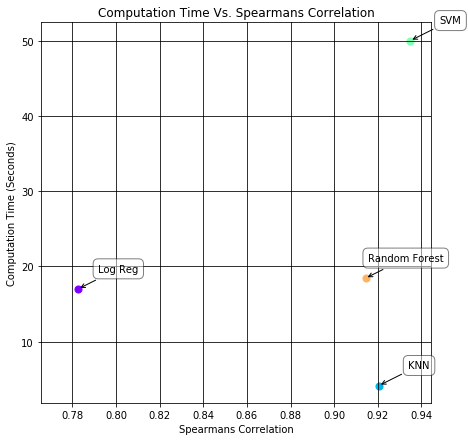

In [0]:
#Code referred from: https://github.com/NaruBeast/Automated-Essay-Grader
import matplotlib.cm as cm
#plot
fig = plt.figure(figsize=(7,7))
print("Algorithm Time Score" )
for x,y,z in zip(labels,times,scores):
    print(x,y,z)  
color=iter(cm.rainbow(np.linspace(0,1,5)))
print(color)
for label, x, y, col  in zip(labels, scores, times, color):
    plt.scatter(x, y, color=col, s = 50)
    plt.grid(color='k')
    plt.annotate(
    label,
    xy = (x, y), xytext = (40, 20),
    textcoords = 'offset points', ha = 'center', va = 'center',
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))  
plt.title('Computation Time Vs. Spearmans Correlation')
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Spearmans Correlation')
plt.show()